In this kernel i build a CNN based multiclass classifier that given an input image predicts which category the image belongs to namely, (No Hidden Message, JMiPOD, JUNIWARD or UERD).
The main highlights of the kernel:
- Approach the problem as multiclass classification instead of binary class.
- Proper split for train and validation set and use competition metric [proposed here](https://www.kaggle.com/anokas/weighted-auc-metric-updated)  to get good estimate of model performance on public lb.
- Illustrate the use of proper augmentation strategy to improve model performance.
- Using imagenet pretrained EfficientNet B0 as model backbone for the classifier.
- One Possible way to convert multiclass probabilities to binary.
- Use test time augmentation to improve lb score.

I have added some comments at each block which further clarifies some of the above mentioned points.

## Updates:
- v3:
    New way of converting multiclass probabilities to binary (basically take sum of probabilities of JMiPOD, JUNIWARD and UERD).
    
    Trained for 5 more epochs.
- v4:
    Based on some of the [discussion](https://www.kaggle.com/c/alaska2-image-steganalysis/discussion/148919#835400), I decided to increase the number of classes. So, now i train a CNN classifier that separates images into one of the following categories [Normal, JMiPOD_75, JMiPOD_90, JMiPOD_95, JUNIWARD_75, JUNIWARD_90, JUNIWARD_95,UERD_75, UERD_90, UERD_95].
- v5: 
    Train for more epochs.
- v6: 
    Train for more epochs. Reduced learning rate every 2 epochs by 0.5.
    Added CoarseDropout and Cutout. It seems to improve performance.



# Load Libraries

In [1]:
!pip install -q efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from albumentations.pytorch import ToTensor
from albumentations import (
    Compose, HorizontalFlip, CLAHE, HueSaturationValue,
    RandomBrightness, RandomContrast, RandomGamma, OneOf, Resize,
    ToFloat, ShiftScaleRotate, GridDistortion, RandomRotate90, Cutout,
    RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CoarseDropout,
    IAAAdditiveGaussianNoise, GaussNoise, OpticalDistortion, RandomSizedCrop, VerticalFlip
)
import os
import torch
import pandas as pd
import numpy as np
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from glob import glob
import torchvision
from torch.utils.data import Dataset
import time
from tqdm.notebook import tqdm
# from tqdm import tqdm
from sklearn import metrics
import cv2
import gc
import torch.nn.functional as F

# Seed everything

In [2]:
seed = 42
print(f'setting everything to seed {seed}')
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

setting everything to seed 42


# Create dataset for training and Validation

### I think the way we perform split is important. Just performing random split mayn't make sense for two reasons:
    - A random split isn't representative of the actual dataset (the class distribution may be different). So, the validation score mayn't be accurate.
    
    - Our aim is to train a classifier that is able to tell whether image has hidden message or not. So, we must ensure that during training we have the corresponding image
    with hidden message. Without the counter example, the discriminatve features that the classifier learns during training mayn't be good.


In [3]:
data_dir = '../input/alaska2-image-steganalysis'
folder_names = ['JMiPOD/', 'JUNIWARD/', 'UERD/']
class_names = ['Normal', 'JMiPOD_75', 'JMiPOD_90', 'JMiPOD_95', 
               'JUNIWARD_75', 'JUNIWARD_90', 'JUNIWARD_95',
                'UERD_75', 'UERD_90', 'UERD_95']
class_labels = { name: i for i, name in enumerate(class_names)}

                                            ImageFileName  Label
160758  ../input/alaska2-image-steganalysis/JUNIWARD/2...      4
139197  ../input/alaska2-image-steganalysis/JUNIWARD/5...      5
142011  ../input/alaska2-image-steganalysis/JUNIWARD/0...      6
133759  ../input/alaska2-image-steganalysis/JUNIWARD/7...      5
179232  ../input/alaska2-image-steganalysis/UERD/74340...      7
215909  ../input/alaska2-image-steganalysis/UERD/74281...      9
884     ../input/alaska2-image-steganalysis/Cover/1509...      0
67071   ../input/alaska2-image-steganalysis/JMiPOD/034...      1
149663  ../input/alaska2-image-steganalysis/JUNIWARD/0...      6
13505   ../input/alaska2-image-steganalysis/Cover/5670...      0


Text(0.5, 1.0, 'Distribution of Classes')

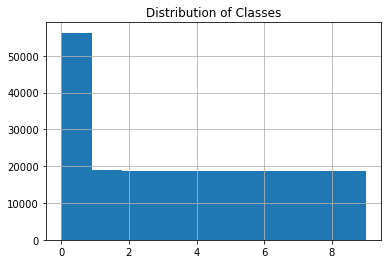

In [4]:
train_df = pd.read_csv('../input/alaska2trainvalsplit/alaska2_train_df.csv')
val_df = pd.read_csv('../input/alaska2trainvalsplit/alaska2_val_df.csv')

print(train_df.sample(10))
train_df.Label.hist()
plt.title('Distribution of Classes')

# Pytorch Dataset

In [5]:
class Alaska2Dataset(Dataset):

    def __init__(self, df, augmentations=None):

        self.data = df
        self.augment = augmentations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fn, label = self.data.loc[idx]
        im = cv2.imread(fn)[:, :, ::-1]
        if self.augment:
            # Apply transformations
            im = self.augment(image=im)
        return im, label


img_size = 512
AUGMENTATIONS_TRAIN = Compose([
    VerticalFlip(p=0.5),
    HorizontalFlip(p=0.5),
    RandomRotate90(p=0.5),
    OneOf([
        Cutout(max_h_size=50,max_w_size=50),
        CoarseDropout(max_height=50, max_width=50)], p=0.5),
    ToFloat(max_value=255),
    ToTensor()
], p=1)


AUGMENTATIONS_TEST = Compose([
    ToFloat(max_value=255),
    ToTensor()
], p=1)


# Images without any augmentation

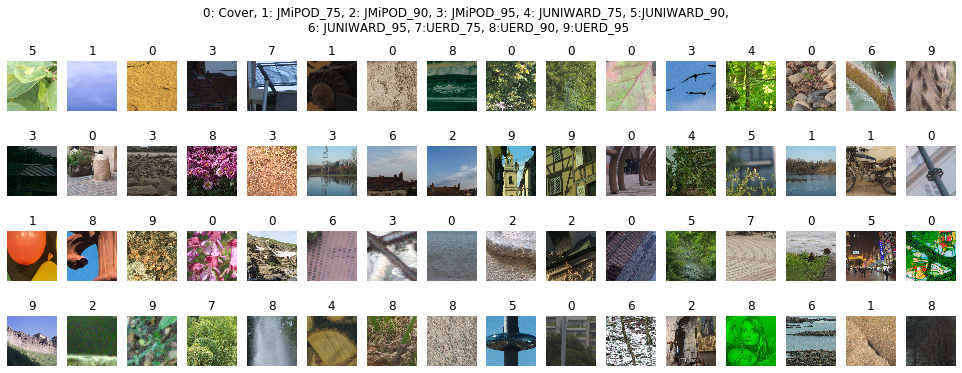

25

In [6]:
temp_df = train_df.sample(64).reset_index(drop=True)
train_dataset = Alaska2Dataset(temp_df, augmentations=AUGMENTATIONS_TEST)
batch_size = 64
num_workers = 0

temp_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          num_workers=num_workers, shuffle=False)


images, labels = next(iter(temp_loader))
images = images['image'].permute(0, 2, 3, 1)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(grid_width+1, grid_height+2))

for i, (im, label) in enumerate(zip(images, labels)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze())
    ax.set_title(str(label.item()))
    ax.axis('off')

plt.suptitle("0: Cover, 1: JMiPOD_75, 2: JMiPOD_90, 3: JMiPOD_95, 4: JUNIWARD_75, 5:JUNIWARD_90,\n 6: JUNIWARD_95, 7:UERD_75, 8:UERD_90, 9:UERD_95")
plt.show()
del images
gc.collect()

# Images after augmentation

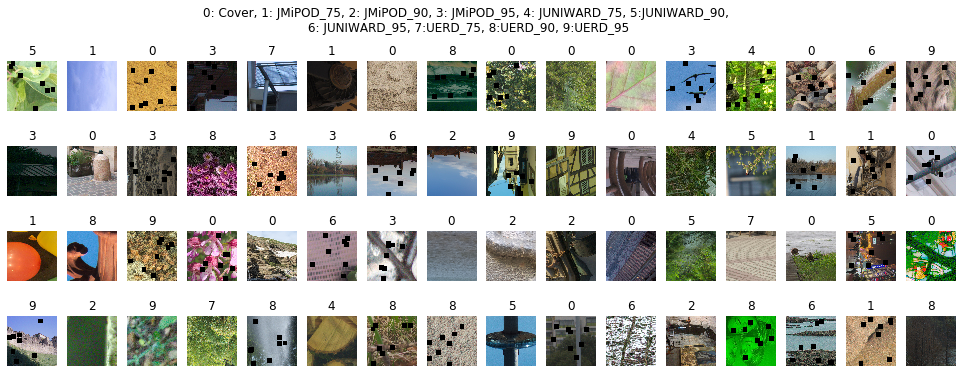

111940

In [7]:
train_dataset = Alaska2Dataset(temp_df, augmentations=AUGMENTATIONS_TRAIN)
batch_size = 64
num_workers = 0

temp_loader = torch.utils.data.DataLoader(train_dataset,
                                          batch_size=batch_size,
                                          num_workers=num_workers, shuffle=False)


images, labels = next(iter(temp_loader))
images = images['image'].permute(0, 2, 3, 1)
max_images = 64
grid_width = 16
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width,
                        figsize=(grid_width+1, grid_height+2))

for i, (im, label) in enumerate(zip(images, labels)):
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(im.squeeze())
    ax.set_title(str(label.item()))
    ax.axis('off')

plt.suptitle("0: Cover, 1: JMiPOD_75, 2: JMiPOD_90, 3: JMiPOD_95, 4: JUNIWARD_75, 5:JUNIWARD_90,\n 6: JUNIWARD_95, 7:UERD_75, 8:UERD_90, 9:UERD_95")
plt.show()
del images, temp_df
gc.collect()

# CNN Model for multiclass classification

I use pretrained Efficient BO. You can try other backbones also. EB7 seems to work slightly better but takes a long time to train.
So, i am sticking with EB0.

In [8]:
class Net(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.model = EfficientNet.from_pretrained('efficientnet-b0')
        # 1280 is the number of neurons in last layer. is diff for diff. architecture
        self.dense_output = nn.Linear(1280, num_classes)

    def forward(self, x):
        feat = self.model.extract_features(x)
        feat = F.avg_pool2d(feat, feat.size()[2:]).reshape(-1, 1280)
        return self.dense_output(feat)

In [9]:
batch_size = 8
num_workers = 8

train_dataset = Alaska2Dataset(train_df, augmentations=AUGMENTATIONS_TRAIN)
valid_dataset = Alaska2Dataset(val_df.sample(1000).reset_index(drop=True), augmentations=AUGMENTATIONS_TEST) #for faster validation sample

train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           num_workers=num_workers,
                                           shuffle=True)

valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                           batch_size=batch_size*2,
                                           num_workers=num_workers,
                                           shuffle=False)

device = 'cuda'
model = Net(num_classes=len(class_labels)).to(device)
# pretrained model in my pc. now i will train on all images for 2 epochs
model.load_state_dict(torch.load('../input/alaska2trainvalsplit/val_loss_6.08_auc_0.875.pth'))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth



Loaded pretrained weights for efficientnet-b0


In [10]:
# https://www.kaggle.com/anokas/weighted-auc-metric-updated

def alaska_weighted_auc(y_true, y_valid):
    tpr_thresholds = [0.0, 0.4, 1.0]
    weights = [2,   1]

    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_valid, pos_label=1)

    # size of subsets
    areas = np.array(tpr_thresholds[1:]) - np.array(tpr_thresholds[:-1])

    # The total area is normalized by the sum of weights such that the final weighted AUC is between 0 and 1.
    normalization = np.dot(areas, weights)

    competition_metric = 0
    for idx, weight in enumerate(weights):
        y_min = tpr_thresholds[idx]
        y_max = tpr_thresholds[idx + 1]
        mask = (y_min < tpr) & (tpr < y_max)
        # pdb.set_trace()

        x_padding = np.linspace(fpr[mask][-1], 1, 100)

        x = np.concatenate([fpr[mask], x_padding])
        y = np.concatenate([tpr[mask], [y_max] * len(x_padding)])
        y = y - y_min  # normalize such that curve starts at y=0
        score = metrics.auc(x, y)
        submetric = score * weight
        best_subscore = (y_max - y_min) * weight
        competition_metric += submetric

    return competition_metric / normalization

In [11]:
criterion = torch.nn.CrossEntropyLoss()
num_epochs = 2
train_loss, val_loss = [], []

for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))
    print('-' * 10)
    model.train()
    running_loss = 0
    tk0 = tqdm(train_loader, total=int(len(train_loader)))
    for im, labels in tk0:
        inputs = im["image"].to(device, dtype=torch.float)
        labels = labels.to(device, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        tk0.set_postfix(loss=(loss.item()))

    epoch_loss = running_loss / (len(train_loader)/batch_size)
    train_loss.append(epoch_loss)
    print('Training Loss: {:.8f}'.format(epoch_loss))

    tk1 = tqdm(valid_loader, total=int(len(valid_loader)))
    model.eval()
    running_loss = 0
    y, preds = [], []
    with torch.no_grad():
        for (im, labels) in tk1:
            inputs = im["image"].to(device, dtype=torch.float)
            labels = labels.to(device, dtype=torch.long)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            y.extend(labels.cpu().numpy().astype(int))
            preds.extend(F.softmax(outputs, 1).cpu().numpy())
            running_loss += loss.item()
            tk1.set_postfix(loss=(loss.item()))

        epoch_loss = running_loss / (len(valid_loader)/batch_size)
        val_loss.append(epoch_loss)
        preds = np.array(preds)
        # convert multiclass labels to binary class
        y = np.array(y)
        labels = preds.argmax(1)
        for class_label in np.unique(y):
            idx = y == class_label
            acc = (labels[idx] == y[idx]).astype(np.float).mean()*100
            print('accuracy for class', class_names[class_label], 'is', acc)
        
        acc = (labels == y).mean()*100
        new_preds = np.zeros((len(preds),))
        temp = preds[labels != 0, 1:]
        new_preds[labels != 0] = temp.sum(1)
        new_preds[labels == 0] = 1 - preds[labels == 0, 0]
        y = np.array(y)
        y[y != 0] = 1
        auc_score = alaska_weighted_auc(y, new_preds)
        print(
            f'Val Loss: {epoch_loss:.3}, Weighted AUC:{auc_score:.3}, Acc: {acc:.3}')

    torch.save(model.state_dict(),
               f"epoch_{epoch}_val_loss_{epoch_loss:.3}_auc_{auc_score:.3}.pth")


Epoch 0/1
----------



Training Loss: 5.98288901



accuracy for class Normal is 61.023622047244096
accuracy for class JMiPOD_75 is 90.47619047619048
accuracy for class JMiPOD_90 is 85.85858585858585
accuracy for class JMiPOD_95 is 43.373493975903614
accuracy for class JUNIWARD_75 is 41.333333333333336
accuracy for class JUNIWARD_90 is 48.717948717948715
accuracy for class JUNIWARD_95 is 35.80246913580247
accuracy for class UERD_75 is 69.62025316455697
accuracy for class UERD_90 is 80.0
accuracy for class UERD_95 is 70.65217391304348
Val Loss: 6.07, Weighted AUC:0.867, Acc: 63.0
Epoch 1/1
----------


Text(0.5, 1.0, 'Loss Plot')

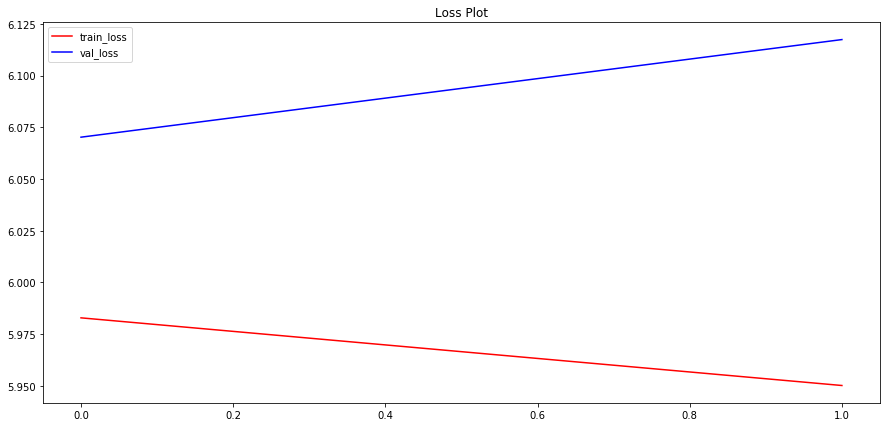

In [12]:
plt.figure(figsize=(15,7))
plt.plot(train_loss, c='r')
plt.plot(val_loss, c='b')
plt.legend(['train_loss', 'val_loss'])
plt.title('Loss Plot')

# Create Inference Dataset

In [13]:
# # Inference
class Alaska2TestDataset(Dataset):

    def __init__(self, df, augmentations=None):

        self.data = df
        self.augment = augmentations

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        fn = self.data.loc[idx][0]
        im = cv2.imread(fn)[:, :, ::-1]

        if self.augment:
            # Apply transformations
            im = self.augment(image=im)

        return im


test_filenames = sorted(glob(f"{data_dir}/Test/*.jpg"))
test_df = pd.DataFrame({'ImageFileName': list(
    test_filenames)}, columns=['ImageFileName'])

batch_size = 16
num_workers = 4
test_dataset = Alaska2TestDataset(test_df, augmentations=AUGMENTATIONS_TEST)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          num_workers=num_workers,
                                          shuffle=False,
                                          drop_last=False)

# Do inference

In [14]:
model.eval()

preds = []
tk0 = tqdm(test_loader)
with torch.no_grad():
    for i, im in enumerate(tk0):
        inputs = im["image"].to(device)
        # flip vertical
        im = inputs.flip(2)
        outputs = model(im)
        # fliplr
        im = inputs.flip(3)
        outputs = (0.25*outputs + 0.25*model(im))
        outputs = (outputs + 0.5*model(inputs))        
        preds.extend(F.softmax(outputs, 1).cpu().numpy())

preds = np.array(preds)
labels = preds.argmax(1)
new_preds = np.zeros((len(preds),))
new_preds[labels != 0] = preds[labels != 0, 1:].sum(1)
new_preds[labels == 0] = 1 - preds[labels == 0, 0]

test_df['Id'] = test_df['ImageFileName'].apply(lambda x: x.split(os.sep)[-1])
test_df['Label'] = new_preds

test_df = test_df.drop('ImageFileName', axis=1)
test_df.to_csv('submission_eb0.csv', index=False)
print(test_df.head())


         Id     Label
0  0001.jpg  0.204660
1  0002.jpg  0.624061
2  0003.jpg  0.529565
3  0004.jpg  0.658830
4  0005.jpg  0.554883
